In [1]:
from pymatgen import MPRester, Composition
from pymatgen.analysis.phase_diagram import PhaseDiagram, PDPlotter
from pymatgen.analysis.phase_diagram import CompoundPhaseDiagram
from pymatgen.entries.computed_entries import ComputedEntry
from pymatgen.apps.borg.hive import VaspToComputedEntryDrone
from pymatgen.entries.compatibility import MaterialsProjectCompatibility
from pymatgen.analysis.reaction_calculator import ComputedReaction
from pymacy.bim.thermo import *
import collections
%matplotlib inline

## get all H, P, V, O, C entries by MPRester 

In [2]:
mp = MPRester()
compat = MaterialsProjectCompatibility()
chemsys = ["H", "P", "V","O", "C"]

all_entries = mp.get_entries_in_chemsys(chemsys)
print(len(all_entries))

410


## remove CO, CO2, H2O, VPO5 entries from all_entries, use experimental data and our own calculations

In [3]:
CO_entries = [e for e in all_entries if e.composition.reduced_formula == "CO"]
print (len(CO_entries))

CO2_entries = [e for e in all_entries if e.composition.reduced_formula == "CO2"]
print (len(CO2_entries))

H2O_entries = [e for e in all_entries if e.composition.reduced_formula == "H2O"]
print (len(H2O_entries))

VPO5_entries = [e for e in all_entries if e.composition.reduced_formula == "VPO5"]
print (len(VPO5_entries))

non_solid = ["CO", "CO2", "H2O", "VPO5"]

entries = list(filter(lambda e: e.composition.reduced_formula not in non_solid, all_entries))
print (len(entries))

3
6
14
13
374


## EC solid phase:
#### Enthalpy of formation of solid at standard conditions = -6.124249 (eV/f.u.) = -590.9 (kJ/mol)
#### (http://webbook.nist.gov/cgi/cbook.cgi?ID=C96491&Units=SI&Mask=2#Thermo-Condensed)
#### ec_form_energy = -6.124249

## EC liquid phase:
#### Enthalpy of formation of solid at standard conditions = -682.8 (kJ/mol)
#### (http://webbook.nist.gov/cgi/cbook.cgi?ID=C96491&Units=SI&Mask=2#Thermo-Condensed)

## get POTCAR of C, H, O for EC to construct its ComputedEntry

In [4]:
potcars = set()
for e in all_entries:
    if len(e.composition) == 1 and e.composition.reduced_formula in ["C", "H2", "O2"]:
        potcars.update(e.parameters["potcar_symbols"]) 

## Get total energy by experimental formation energy, elemental energies and correction to construct EC ComputedEntry
## Apply corection for gas such as O2 etc. Ref: https://journals.aps.org/prb/pdf/10.1103/PhysRevB.73.195107

In [5]:
factor = 1000.0 / 6.0221409e23 / 1.60217662e-19
ec_form_energy = -682.8 * factor
print (ec_form_energy)

ec = ComputedEntry(composition="C3H4O3", energy=0, parameters={"potcar_symbols": list(potcars)})
ec.data["oxide_type"] = "oxide"

# MaterialsProjectCompatibility
ec = compat.process_entry(ec)

pd = PhaseDiagram(all_entries)
ec.uncorrected_energy = ec_form_energy + sum([pd.el_refs[el].energy_per_atom * amt \
                                              for el, amt in ec.composition.items()]) - ec.correction
print (pd.get_form_energy(ec))
print (ec.composition.reduced_formula)

-7.076723218616562
-7.076723218616564
H4(CO)3


In [6]:
# use my own calculation entries
vopo4 = []
vc = VaspToComputedEntryDrone()
for d in ["VOPO4/"]:
    e = vc.assimilate(d)
    e.data["oxide_type"] = "oxide"
    e = compat.process_entry(e)
    vopo4.append(e)

hxvopo4 = []
for d in ["HVOPO4/", "H2VOPO4/"]:
    e = vc.assimilate(d)
    e.data["oxide_type"] = "oxide"
    e = compat.process_entry(e)
    hxvopo4.append(e) 

## CO solid phase:
#### Enthalpy of formation of solid at standard conditions = -1.15 (eV/f.u.) = -110.5 (kJ/mol)
#### https://en.wikipedia.org/wiki/Carbon_monoxide_%28data_page%29

## CO gas phase:
#### Enthalpy of formation of gas at standard conditions = -1.15 (eV/f.u.) = -110.53 (kJ/mol)
#### https://en.wikipedia.org/wiki/Carbon_monoxide_%28data_page%29

In [7]:
potcars = set()
for e in all_entries:
    if len(e.composition) == 1 and e.composition.reduced_formula in ["C", "O2"]:
        potcars.update(e.parameters["potcar_symbols"])

print(potcars)
co_form_energy = -110.53 * factor
print(co_form_energy)

co = ComputedEntry(composition="CO", energy=0, parameters={"potcar_symbols": list(potcars)})
co.data["oxide_type"] = "oxide"
co = compat.process_entry(co)
print(co)

pd = PhaseDiagram(all_entries)
co.uncorrected_energy = co_form_energy + sum([pd.el_refs[el].energy_per_atom * amt \
                                              for el, amt in co.composition.items()]) - co.correction

print (pd.get_form_energy(co))
print (co.composition.reduced_formula)
print ("CO energy:", co.energy)

{'pbe O', 'pbe C'}
-1.1455627084851914
ComputedEntry None - C1 O1
Energy = 0.0000
Correction = -0.7023
Parameters:
potcar_symbols = ['pbe O', 'pbe C']
Data:
oxide_type = oxide
-1.1455627084851905
CO
CO energy: -15.306564208485192


## CO2 gas phase:
#### Enthalpy of formation of gas at standard conditions = -4.43 (eV/f.u.) = −393.52 (kJ/mol)
#### https://en.wikipedia.org/wiki/Carbon_dioxide_%28data_page%29

In [8]:
potcars = set()
for e in all_entries:
    if len(e.composition) == 1 and e.composition.reduced_formula in ["C", "O2"]:
        potcars.update(e.parameters["potcar_symbols"])
print (potcars)

co2_form_energy = -393.52 * factor
print (co2_form_energy)

co2 = ComputedEntry(composition="CO2", energy=0, parameters={"potcar_symbols": list(potcars)})
co2.data["oxide_type"] = "oxide"
co2 = compat.process_entry(co2)
print (co2)

pd = PhaseDiagram(all_entries)
co2.uncorrected_energy = co2_form_energy + sum([pd.el_refs[el].energy_per_atom * amt 
                                                for el, amt in co2.composition.items()]) - co2.correction

print (pd.get_form_energy(co2))
print (co2.composition.reduced_formula)
print (co2.energy)

{'pbe O', 'pbe C'}
-4.078547335954877
ComputedEntry None - C1 O2
Energy = 0.0000
Correction = -1.4046
Parameters:
potcar_symbols = ['pbe O', 'pbe C']
Data:
oxide_type = oxide
-4.078547335954877
CO2
-23.17507675470488


## H2O liquid phase:
#### Enthalpy of formation of liquid at standard conditions = -286.629 (kJ/mol)
#### http://www1.lsbu.ac.uk/water/water_properties.html

In [9]:
potcars = set()
for e in all_entries:
    if len(e.composition) == 1 and e.composition.reduced_formula in ["H2", "O2"]:
        potcars.update(e.parameters["potcar_symbols"])

print (potcars)

h2o_form_energy = -286.629 * factor
print (h2o_form_energy)

h2o = ComputedEntry(composition="H2O", energy=0, parameters={"potcar_symbols": list(potcars)})
h2o.data["oxide_type"] = "oxide"
h2o = compat.process_entry(h2o)
print (h2o)

pd = PhaseDiagram(all_entries)
h2o.uncorrected_energy = h2o_form_energy + sum([pd.el_refs[el].energy_per_atom * amt for el, amt in h2o.composition.items()]) - h2o.correction

print (pd.get_form_energy(h2o))
print (h2o.composition.reduced_formula)
print (h2o.energy)

{'pbe O', 'pbe H'}
-2.9707002042015915
ComputedEntry None - H2 O1
Energy = 0.0000
Correction = -0.7023
Parameters:
potcar_symbols = ['pbe O', 'pbe H']
Data:
oxide_type = oxide
-2.9707002042015915
H2O
-14.385701445711593


In [10]:
entry1 = vopo4[0]
entry2 = ec
useful_entries = entries + hxvopo4 + [h2o, co2, co]
print(len(useful_entries))

379


Singular matrix
Singular matrix
Singular matrix
Singular matrix
Singular matrix
Singular matrix
Singular matrix
Singular matrix
Singular matrix
Singular matrix
Singular matrix
Singular matrix
Singular matrix
Singular matrix
Singular matrix
Singular matrix
Singular matrix
Singular matrix
Singular matrix
Singular matrix
Singular matrix
Singular matrix
1 - 0.9200 VPO5 + 0.0800 H4(CO)3 -> 0.0600 V3O7 + 0.3200 VPHO5 + 0.3000 VP2O7 + 0.1200 V(CO3)2
2 - 0.9091 VPO5 + 0.0909 H4(CO)3 -> 0.3636 VPHO5 + 0.1364 VO2 + 0.2727 VP2O7 + 0.1364 V(CO3)2
3 - 0.8947 VPO5 + 0.1053 H4(CO)3 -> 0.4211 VPHO5 + 0.1579 VP2O7 + 0.1579 V(CO3)2 + 0.1579 VPO4
4 - 0.8462 VPO5 + 0.1538 H4(CO)3 -> 0.0769 VP2O7 + 0.0769 V(CO3)2 + 0.3077 H2CO3 + 0.6923 VPO4
5 - 0.8421 VPO5 + 0.1579 H4(CO)3 -> 0.0263 V2P5O16 + 0.0789 V(CO3)2 + 0.3158 H2CO3 + 0.7105 VPO4
6 - 0.8400 VPO5 + 0.1600 H4(CO)3 -> 0.0400 V(PO3)3 + 0.0800 V(CO3)2 + 0.3200 H2CO3 + 0.7200 VPO4
7 - 0.7500 VPO5 + 0.2500 H4(CO)3 -> 0.5000 H2CO3 + 0.7500 VPO4 + 0.2500 C
8

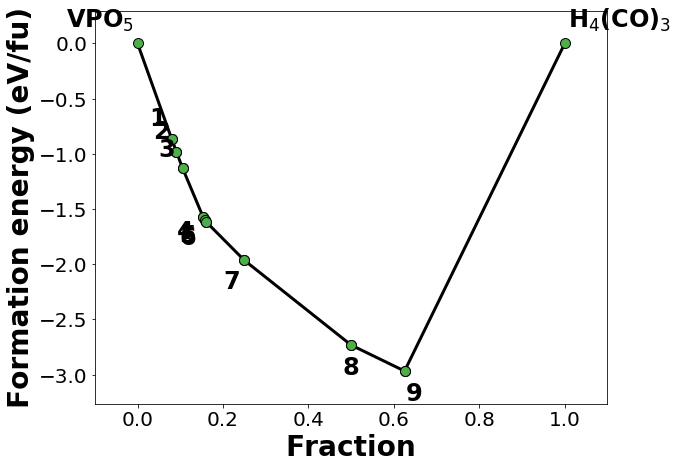

In [11]:
ra = ReactionAnalysis(entry1=entry1,entry2=entry2,all_entries=useful_entries)
ra.get_compound_pd(show_unstable=False, show_label=True)
for i, l in ra.labels.items():
        print("%s - %s" % (i, l))

In [12]:
from scipy import stats
import numpy as np

%matplotlib inline
import matplotlib as mpl

mpl.rcParams['axes.linewidth']=3
mpl.rcParams['lines.markeredgewidth']=2
mpl.rcParams['lines.linewidth']=3
mpl.rcParams['lines.markersize']=13
mpl.rcParams['xtick.major.width']=3
mpl.rcParams['xtick.major.size']=8
mpl.rcParams['xtick.minor.width']=3
mpl.rcParams['xtick.minor.size']=4
mpl.rcParams['ytick.major.width']=3
mpl.rcParams['ytick.major.size']=8
mpl.rcParams['ytick.minor.width']=3
mpl.rcParams['ytick.minor.size']=4

1 - 0.9200 VPO5 + 0.0800 H4(CO)3 -> 0.0600 V3O7 + 0.3200 VPHO5 + 0.3000 VP2O7 + 0.1200 V(CO3)2
2 - 0.9091 VPO5 + 0.0909 H4(CO)3 -> 0.3636 VPHO5 + 0.1364 VO2 + 0.2727 VP2O7 + 0.1364 V(CO3)2
3 - 0.8947 VPO5 + 0.1053 H4(CO)3 -> 0.4211 VPHO5 + 0.1579 VP2O7 + 0.1579 V(CO3)2 + 0.1579 VPO4
4 - 0.8462 VPO5 + 0.1538 H4(CO)3 -> 0.0769 VP2O7 + 0.0769 V(CO3)2 + 0.3077 H2CO3 + 0.6923 VPO4
5 - 0.8421 VPO5 + 0.1579 H4(CO)3 -> 0.0263 V2P5O16 + 0.0789 V(CO3)2 + 0.3158 H2CO3 + 0.7105 VPO4
6 - 0.8400 VPO5 + 0.1600 H4(CO)3 -> 0.0400 V(PO3)3 + 0.0800 V(CO3)2 + 0.3200 H2CO3 + 0.7200 VPO4
7 - 0.7500 VPO5 + 0.2500 H4(CO)3 -> 0.5000 H2CO3 + 0.7500 VPO4 + 0.2500 C
8 - 0.5000 VPO5 + 0.5000 H4(CO)3 -> 0.5000 VPH2O5 + 0.5000 H2CO3 + 1.0000 C
9 - 0.3750 VPO5 + 0.6250 H4(CO)3 -> 0.3750 VP(H2O3)2 + 0.5000 H2CO3 + 1.3750 C


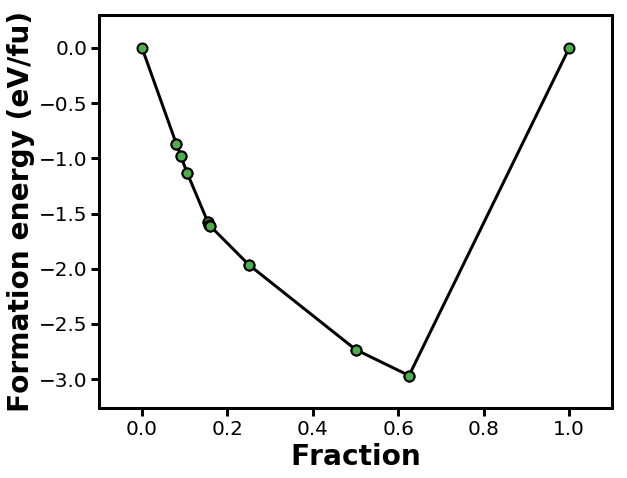

In [13]:
plt = ra.get_compound_pd(show_unstable=False, show_label=False)
for i, l in ra.labels.items():
        print ("%s - %s" % (i, l))